Investigate the glacier-scale and regional-scale trend in water area over time

In [1]:
import os
import rasterio as rio
import numpy as np
import shapely 
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
import matplotlib as mpl

In [2]:
# define folder and file paths
folder_HMA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"HMA2")
folder_glaciers = os.path.join(folder_HMA, 'Glacier Products')
folder_datasets = os.path.join(folder_HMA, 'Datasets')
fp_rgi = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_full_rgi.shp')
fp_dc = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_dc_rgi.shp')
fp_regions = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'subregion_boundaries.shp')

In [3]:
# open the rgi gdf, regions gdf
rgi_gdf = gpd.read_file(fp_rgi).to_crs("ESRI:102025")
dc_gdf = gpd.read_file(fp_dc).to_crs("ESRI:102025")
regions_gdf = gpd.read_file(fp_regions).to_crs("ESRI:102025")

# add the o3region as a column to each rgi
regions_gdf = regions_gdf.rename({"id":"o3region"}, axis=1)
rgi_gdf = rgi_gdf.sjoin(regions_gdf[["o3region","geometry"]])
dc_gdf = dc_gdf.sjoin(regions_gdf[["o3region","geometry"]])

In [4]:
# matplotlib stuff
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'

In [5]:
# open the water by distance data for each glacier, format into a single df
c=0

# list to hold all the info
df_all_norm_area = []

for idx, row in rgi_gdf.iterrows():
    c+=1
    # if c>2: continue
    
    rgi_id = row['rgi_id']
    o1region = row['o1region']
    o2region = row['o2region']
    o3region = row['o3region']
    
    # if o1region!='15':continue
    # print progress
    # print(c, "of", len(rgi_gdf), rgi_id)
    if c%100==0: print(c, "of", len(rgi_gdf), rgi_id)

    # open glacier-specific info    
    path_open = os.path.join(folder_glaciers, rgi_id, 'Water', 'glacier_water_distances.csv')
    df_g = pd.read_csv(path_open, index_col=None, header=0).squeeze()
    
    # combine columns that are separate branches. calculate total water in each distance band
    old_cols = df_g.columns.values[1:]
    all_branches = np.unique([ int(i.split("_")[0]) for i in old_cols ])
    all_ys = [1988,1990,1992,1994,1996,1998,2000,2002,2004] + list(range(2005,2024))
    
    df_water = pd.DataFrame({"distance":df_g['distance']})
    for y in all_ys:
        subset = df_g[ [ f"{n}_{y}" for n in all_branches ] ]
        df_water[f"{y}"] = subset.sum(axis=1)
     
    # repeat for debris covered area
    path_open = os.path.join(folder_glaciers, rgi_id, 'Base Products', 'glacier_dca_distances.csv')
    df_dca = pd.read_csv(path_open, index_col=None, header=0).squeeze()
    
    df_dca = pd.DataFrame({'distance':df_dca['distance'],
                           'dca': df_dca[df_dca.columns.values[1:]].sum(axis=1) })    
    
    # normalize to n bands along glacier
    n_bands = 20
    mind = np.nanmin(df_water['distance'])
    maxd = np.nanmax(df_water['distance'])
    norm_bands = np.linspace(0, maxd+1, n_bands+1)    
    
    # for each band
    for i in range(n_bands):
        
        # get rows that correspond to these bands only
        bmin = norm_bands[i]
        bmax = norm_bands[i+1]
        df_water_b = df_water[ (df_water['distance']>=bmin) & (df_water['distance']<bmax) ]
        df_dca_b = df_dca[ (df_dca['distance']>=bmin) & (df_dca['distance']<bmax) ]
        
        # sum each column
        df_water_b = df_water_b.sum(axis=0)
        df_dca_b = df_dca_b.sum(axis=0)
        
        # initialize dic to store info
        out_dic_w = {'rgi_id':rgi_id, 'o1region':row['o1region'], 'o2region':row['o2region'], 'o3region':row['o3region'],
               'length':maxd, 'band':i, 'dca':df_dca_b['dca'] }
        
        # add annual water totals to dic
        out_dic_w.update( dict(df_water_b.drop('distance')) )
        
        # add dictionary to list, and we'll concat to df all at once
        df_all_norm_area.append(out_dic_w)

# combine into df holding water within distance bands in each year
df_all_norm_area = pd.DataFrame(df_all_norm_area)

# divide by total dca to get % water in each band each year
df_all_norm_percent = df_all_norm_area.copy()
for y in [1988,1990,1992,1994,1996,1998,2000,2002,2004] + list(range(2005,2024)):
    df_all_norm_percent[str(y)] = df_all_norm_percent[str(y)]/df_all_norm_percent['dca']*100

print("All done!")

100 of 769 RGI2000-v7.0-G-14-06944
200 of 769 RGI2000-v7.0-G-13-71307
300 of 769 RGI2000-v7.0-G-14-15108
400 of 769 RGI2000-v7.0-G-14-32564
500 of 769 RGI2000-v7.0-G-15-01330
600 of 769 RGI2000-v7.0-G-15-05352
700 of 769 RGI2000-v7.0-G-15-08609
All done!


In [6]:
# repeat to get dhdt profile on each glacier
# open the dhdt by distance data for each glacier, format into a single df
c=0

# list to hold all the info
df_all_norm_dhdt = []

for idx, row in rgi_gdf.iterrows():
    c+=1
    # if c>2: continue
    
    rgi_id = row['rgi_id']
    o1region = row['o1region']
    o2region = row['o2region']
    o3region = row['o3region']
    
    # if o1region!='15':continue
    # print progress
    # print(c, "of", len(rgi_gdf), rgi_id)
    if c%100==0: print(c, "of", len(rgi_gdf), rgi_id)

    # open glacier-specific info    
    path_open = os.path.join(folder_glaciers, rgi_id, 'Base Products', 'glacier_dhdt_distances.csv')
    df_g = pd.read_csv(path_open, index_col=None, header=0).squeeze()
    
    # combine columns that are separate branches. calculate average dhdt in each distance band
    old_cols = df_g.columns.values[1:]
    all_branches = np.unique([ int(i.split("_")[0]) for i in old_cols ])
    all_ys = [ "2000-01-01_2005-01-01", "2000-01-01_2010-01-01", "2000-01-01_2020-01-01",
               "2005-01-01_2010-01-01", "2010-01-01_2015-01-01", '2015-01-01_2020-01-01',
               "2010-01-01_2020-01-01"]
    
    df_dhdt = pd.DataFrame({"distance":df_g['distance']})
    for y in all_ys:
        subset = df_g[ [ f"{n}_{y}" for n in all_branches ] ]
        df_dhdt[f"{y}"] = subset.mean(axis=1)
    
    # normalize to n bands along glacier
    n_bands = 20
    mind = np.nanmin(df_dhdt['distance'])
    maxd = np.nanmax(df_dhdt['distance'])
    norm_bands = np.linspace(0, maxd+1, n_bands+1)    
    
    # for each band
    for i in range(n_bands):
        
        # get rows that correspond to these bands only
        bmin = norm_bands[i]
        bmax = norm_bands[i+1]
        df_dhdt_b = df_dhdt[ (df_dhdt['distance']>=bmin) & (df_dhdt['distance']<bmax) ]
        
        # average column
        df_dhdt_b = df_dhdt_b.mean(axis=0)
        
        # initialize dic to store info
        out_dic_dh = {'rgi_id':rgi_id, 'o1region':row['o1region'], 'o2region':row['o2region'], 'o3region':row['o3region'],
               'length':maxd, 'band':i, 'dca':df_dca_b['dca'] }
        
        # add dhdt averages to dic
        out_dic_dh.update( dict(df_dhdt_b.drop('distance')) )
        
        # add dictionary to list, and we'll concat to df all at once
        df_all_norm_dhdt.append(out_dic_dh)

# combine into df holding dhdt within distance bands in each year
df_all_norm_dhdt = pd.DataFrame(df_all_norm_dhdt)

print("All done!")

100 of 769 RGI2000-v7.0-G-14-06944
200 of 769 RGI2000-v7.0-G-13-71307
300 of 769 RGI2000-v7.0-G-14-15108
400 of 769 RGI2000-v7.0-G-14-32564
500 of 769 RGI2000-v7.0-G-15-01330
600 of 769 RGI2000-v7.0-G-15-05352
700 of 769 RGI2000-v7.0-G-15-08609
All done!


In [7]:
# load in the list of lake-terminating glaciers, so we can remove those if we want
path_open = os.path.join(folder_datasets, 'lake-terminating glaciers', 'rgi_lake_terminating.csv')
df_lake_term = pd.read_csv(path_open)
rgi_lake_term = df_lake_term['rgi_id'].values

In [8]:
# create subsets of lake terminating vs non-lake terminating so we can compare
df_all_norm_dhdt_lt = df_all_norm_dhdt[df_all_norm_dhdt['rgi_id'].isin(rgi_lake_term)]
df_all_norm_dhdt_nlt = df_all_norm_dhdt[~df_all_norm_dhdt['rgi_id'].isin(rgi_lake_term)]

# choose which to use for all of the following regional plots
df_to_use_from_here = df_all_norm_dhdt_nlt  #df_all_norm_percent, df_all_norm_percent_nlt

# lets make a separate df that includes only longer glaciers
df_long = df_to_use_from_here[df_to_use_from_here['length']>=2000]

In [9]:
print(len(df_to_use_from_here['rgi_id'].unique()))
print(len(df_long['rgi_id'].unique()))

747
648


In [10]:
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'

In [11]:
# plot a single glacier's data over time
def plot_single_glacier(rgi_id, glacier_name):
    # plot annual timeseries of a single glacier ( provide either glacier name or rgi_id)
    rgi_id = rgi_id # choose which you want to provide
    glacier_name = glacier_name


    # get the rgi_id if glacier name was provided
    if glacier_name: rgi_id = rgi_gdf[rgi_gdf['glac_name'].str.contains(glacier_name)==True]['rgi_id'].values[0]

    # subset to this glacier's data
    g_df = df_all_norm_percent[df_all_norm_percent['rgi_id']==rgi_id]

    # define intervals to use
    intervals = [[1990,1999], [2000,2004], [2005,2009], [2010,2014], [2015,2019], [2020,2023]]
    all_ys = [1988,1990,1992,1994,1996,1998,2000,2002,2004] + list(range(2005,2024))

    # iterate through a color ramp. new color for each interval
    colors_to_use = iter(plt.cm.magma_r(np.linspace(0.1, 0.9, len(intervals))))


    # initiate figure
    fig,axs = plt.subplots(figsize=(6,3))

    # define xs of the plot
    xs = np.linspace(0, 1, len(g_df))

    # for each interval, subset the data and plot it
    for interval in intervals:

        # format and subset
        ymin = interval[0]
        ymax = interval[1]
        subset_ys = [ str(y) for y in np.arange(ymin,ymax+1) if y in all_ys]
        
        # subset to just these years' column take median by year
        subset_df = g_df[ subset_ys ]
        areas = subset_df.median(axis=1)#.values

        # grab which color we want to use
        color_to_use = next(colors_to_use)

        # plot
        axs.plot(xs, areas, label=f"{ymin}-{ymax}", color=color_to_use)

    # add legend
    axs.legend(loc='center left', title='Years', bbox_to_anchor=(1,0.5))

    # formatting
    axs.grid(zorder=1, linestyle='dashed', linewidth=0.5)
    axs.set_xlabel("Distance from terminus")
    axs.set_ylabel("SGL Area (%)")
    axs.set_ylim(0,)

    # title
    glacier_name = rgi_gdf[rgi_gdf['rgi_id']==rgi_id]['glac_name'].values[0]
    axs.set_title(f"Name: {glacier_name}\nRGI_ID: {rgi_id}")

    plt.tight_layout()
    
    
    
    
    # separate figure to plot dhdt along-profile by years
    # subset to this glacier's data
    g_df = df_all_norm_dhdt[df_all_norm_dhdt['rgi_id']==rgi_id]

    # define intervals to use
    intervals = ['2000-01-01_2005-01-01', '2005-01-01_2010-01-01',
                 '2010-01-01_2015-01-01', '2015-01-01_2020-01-01']
    
    # get max value so we can normalize by that
    norm_value = np.nanmax(np.abs(g_df[intervals].values))

    # iterate through a color ramp. new color for each interval
    colors_to_use = iter(plt.cm.magma_r(np.linspace(0.1, 0.9, len(intervals))))


    # initiate figure
    fig,axs = plt.subplots(figsize=(6,3))

    # define xs of the plot
    xs = np.linspace(0, 1, len(g_df))
    
    # plot long-term average in black dashed line
    axs.plot(xs, g_df['2000-01-01_2020-01-01'].values, label=f"{interval}", color='black', linestyle='dashed')

    # for each interval, subset the data and plot it
    for interval in intervals:

        # grab dhdt in each year
        areas = g_df[interval].values

        # grab which color we want to use
        color_to_use = next(colors_to_use)

        # plot
        axs.plot(xs, areas, label=f"{interval}", color=color_to_use)

    # add legend
    axs.legend(loc='center left', title='Years', bbox_to_anchor=(1,0.5))

    # formatting
    axs.grid(zorder=1, linestyle='dashed', linewidth=0.5)
    axs.set_xlabel("Distance from terminus")
    axs.set_ylabel("dh/dt (m/yr)")
    # axs.set_ylim(0,)

    # title
    glacier_name = rgi_gdf[rgi_gdf['rgi_id']==rgi_id]['glac_name'].values[0]
    axs.set_title(f"Name: {glacier_name}\nRGI_ID: {rgi_id}")

    plt.tight_layout()
    

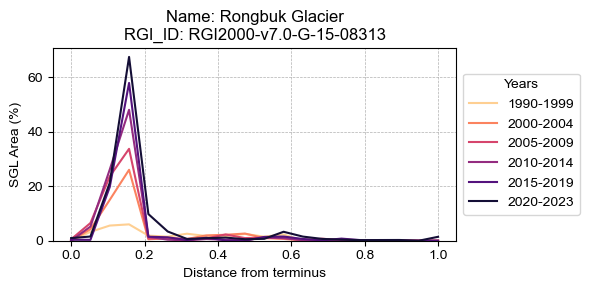

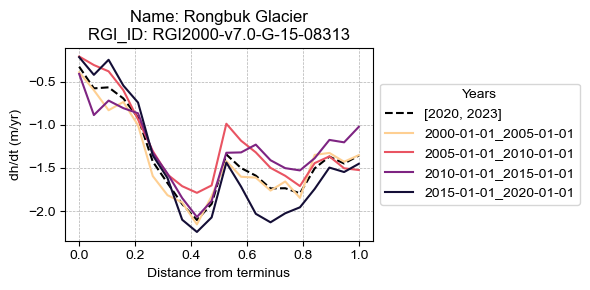

In [12]:
rgi_id = 'RGI2000-v7.0-G-15-08331' # choose which you want to provide
glacier_name = 'Rong'
plot_single_glacier(rgi_id, glacier_name)

In [37]:
# lets load list of glacier with substanial sgls so we can compare
path_open = os.path.join(folder_datasets, 'substantial_glaciers.csv')
df_substantial = pd.read_csv(path_open)
rgi_substantial = df_substantial['rgi_id']

In [49]:
# normalize each glacier's data by its maximum rate of thinning
df_dhdt_relative = []

intervals = ['2000-01-01_2005-01-01', '2005-01-01_2010-01-01',
                 '2010-01-01_2015-01-01', '2015-01-01_2020-01-01', '2000-01-01_2020-01-01']

for rgi_i in df_all_norm_dhdt['rgi_id'].unique():
    
    # subset to this rgi's data
    g_df = df_all_norm_dhdt[df_all_norm_dhdt['rgi_id']==rgi_i]

    # get mean value so we can normalize by that
    norm_value = np.abs(np.nanmean(g_df['2000-01-01_2020-01-01'].values))
    
    # maybe we should actually normalize to 0-1
    # 0 being the least dhdt, 1 being the most
    norm_max = np.nanmax(np.abs(g_df['2000-01-01_2020-01-01'].values))
    norm_min = np.nanmin(np.abs(g_df['2000-01-01_2020-01-01'].values))

    # add region info and such
    g_df_norm = g_df[intervals]/norm_value
    # g_df_norm = (g_df[intervals]-norm_min) / (norm_max-norm_min)
    g_df_norm['rgi_id'] = g_df['rgi_id']
    g_df_norm['o1region'] = g_df['o1region']
    g_df_norm['o2region'] = g_df['o2region']
    g_df_norm['o3region'] = g_df['o3region']
    g_df_norm['length'] = g_df['length']
    g_df_norm['band'] = g_df['band']
    g_df_norm['dca'] = g_df['dca']
    
    # add to list
    df_dhdt_relative.append(g_df_norm)
    
df_dhdt_relative = pd.concat(df_dhdt_relative)

C:\Users\lzell\AppData\Local\Temp\ipykernel_15244\1117306207.py:13: RuntimeWarning: Mean of empty slice
  norm_value = np.abs(np.nanmean(g_df['2000-01-01_2020-01-01'].values))
C:\Users\lzell\AppData\Local\Temp\ipykernel_15244\1117306207.py:17: RuntimeWarning: All-NaN slice encountered
  norm_max = np.nanmax(np.abs(g_df['2000-01-01_2020-01-01'].values))
C:\Users\lzell\AppData\Local\Temp\ipykernel_15244\1117306207.py:18: RuntimeWarning: All-NaN slice encountered
  norm_min = np.nanmin(np.abs(g_df['2000-01-01_2020-01-01'].values))


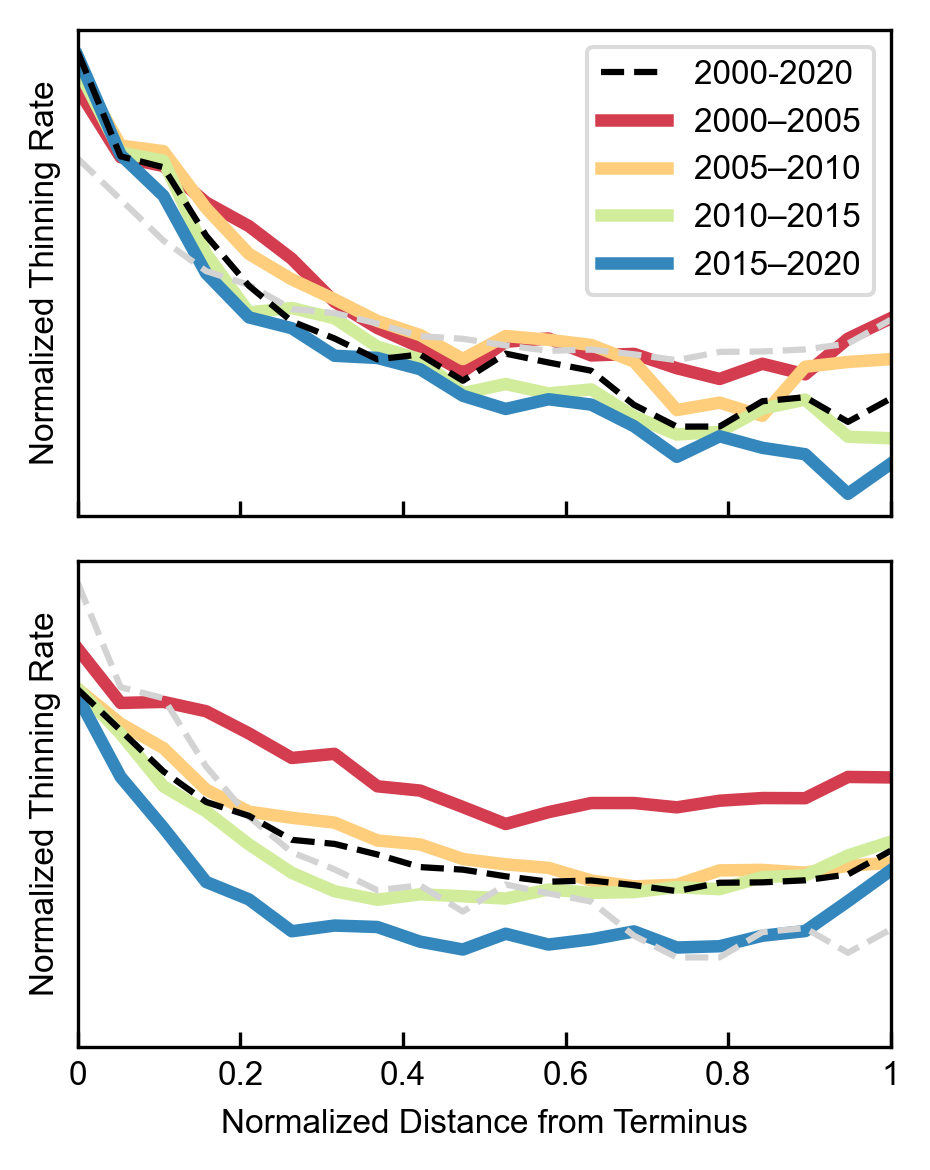

In [59]:
### start figure here

# define xs of the plot
xs = np.linspace(0, 1, len(df_to_use['band'].unique()))
intervals = ['2000-01-01_2005-01-01', '2005-01-01_2010-01-01',
             '2010-01-01_2015-01-01', '2015-01-01_2020-01-01',]
lw_c = 3

##### initiate figure
fig,axs = plt.subplots(2,1, figsize=(3.2,4), sharex=True, sharey=True, dpi=300)

### first plot glacier with substanial sgls
df_to_use = df_dhdt_relative
df_to_use = df_to_use[df_to_use['rgi_id'].isin(rgi_substantial)]
colors_to_use = iter(plt.cm.Spectral(np.linspace(0.1, 0.9, len(intervals))))

# add 20-year average in black dashed line
areas_av = df_to_use[['band','2000-01-01_2020-01-01']].groupby('band').median()
axs[0].plot(xs, areas_av, color='black', label="2000-2020", linestyle='dashed', zorder=3)
axs[1].plot(xs, areas_av, color='lightgrey', label="2000–2020", linestyle='dashed', zorder=2)

# for each year interval, subset the data and plot it
for interval in intervals:
    # subset to just this column, group by band, take median/mean
    subset_df = df_to_use[ ['band', interval] ]
    areas = subset_df.groupby('band').median()
    axs[0].plot(xs, areas, color=next(colors_to_use), zorder=1,
                label=f"{interval[:4]}–{interval[11:15]}", linewidth=lw_c)

    
### glaciers without sgls
df_to_use = df_dhdt_relative
df_to_use = df_to_use[~df_to_use['rgi_id'].isin(rgi_substantial)]
colors_to_use = iter(plt.cm.Spectral(np.linspace(0.1, 0.9, len(intervals))))

# add 20-year average in black dashed line
areas_av2 = df_to_use[['band','2000-01-01_2020-01-01']].groupby('band').median()
axs[1].plot(xs, areas_av2, color='black', label="2000–2020", linestyle='dashed', zorder=3)
axs[0].plot(xs, areas_av2, color='lightgrey', linestyle='dashed', zorder=2)

# for each year interval, subset the data and plot it
for interval in intervals:
    # subset to just this column, group by band, take median/mean
    subset_df = df_to_use[ ['band', interval] ]
    areas = subset_df.groupby('band').median()
    axs[1].plot(xs, areas, color=next(colors_to_use), zorder=1,
                label=f"{interval[:4]}–{interval[11:15]}", linewidth=lw_c )

    
# formatting
for ax in axs:
    # ax.grid(zorder=1, linestyle='dashed', linewidth=0.5)
    # ax.set_xlabel("Distance from terminus")
    ax.set_ylabel("Normalized Thinning Rate", fontsize=8)
    ax.set_xlim(0,1)
    # ax.set_ylim(-1.2,-0.5)
    ax.set_yticks([])
    ax.set_xticks(np.arange(0,1.1,0.2), ["0","0.2","0.4","0.6","0.8","1"], fontsize=8)
    ax.tick_params(axis="both",direction="in")

axs[1].set_xlabel("Normalized Distance from Terminus", fontsize=8)

# add legend
axs[0].legend(loc='upper right', title='', ncols=1, framealpha=0.7, fontsize=8, bbox_to_anchor=(1,1))

# add text for labels
# axs[0].text(0.98,0.90, 'a. Glaciers with SGLs', ha='right', transform=axs[0].transAxes)
# axs[1].text(0.98,0.90, 'b. Glaciers without SGLs', ha='right', transform=axs[1].transAxes)
plt.tight_layout()

save=1
if save:
    plt.savefig(os.path.join(folder_HMA,'Figures','slope and dhdt',f'dhdt.png'),
                transparent=False, bbox_inches='tight', dpi=300)

In [31]:
# ### start figure here
# df_to_use = df_dhdt_relative
# df_to_use = df_to_use[df_to_use['o1region']=='14']
# # define xs of the plot
# xs = np.linspace(0, 1, len(df_to_use['band'].unique()))
       
# intervals = ['2000-01-01_2005-01-01', '2005-01-01_2010-01-01',
#              '2010-01-01_2015-01-01', '2015-01-01_2020-01-01',]

# # define colors
# colors_to_use = iter(plt.cm.magma_r(np.linspace(0.1, 0.9, len(intervals))))

# # initiate figure
# fig,axs = plt.subplots(figsize=(6.5,3))

# # add 20-year average in black dashed line
# areas = df_to_use[['band','2000-01-01_2020-01-01']].groupby('band').mean()
# axs.plot(xs, areas, color='black', label="2000-2020", linestyle='dashed')

# # for each year interval, subset the data and plot it
# for interval in intervals:

#     # subset to just this column
#     subset_df = df_to_use[ ['band', interval] ]

#     # group by band, take median/mean
#     areas = subset_df.groupby('band').mean()

#     # grab which color we want to use
#     color_to_use = next(colors_to_use)

#     # plot
#     axs.plot(xs, areas, color=color_to_use, label=f"{interval[:4]}-{interval[11:15]}", )

# # formatting
# axs.grid(zorder=1, linestyle='dashed', linewidth=0.5)
# axs.set_xlabel("Distance from terminus")
# axs.set_ylabel("dhdt")
# axs.set_xlim(-0.01,1.01)
# # axs.set_ylim(-1,0)

# # add legend
# axs.legend(loc='upper left', title='Years', ncols=1, bbox_to_anchor=(0.95,1), framealpha=0.7)

# plt.tight_layout()

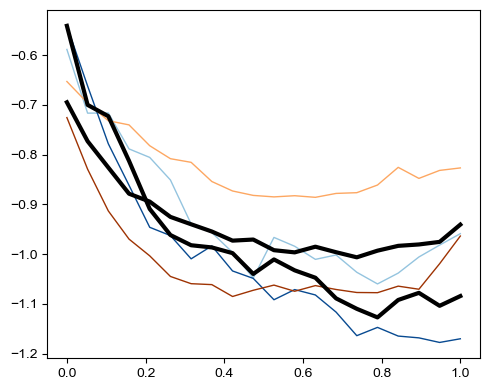

In [17]:
### start figure here

# define xs of the plot
xs = np.linspace(0, 1, len(df_to_use['band'].unique()))
intervals = ['2000-01-01_2005-01-01', '2005-01-01_2010-01-01',
             '2010-01-01_2015-01-01', '2015-01-01_2020-01-01',]
intervals = ['2000-01-01_2005-01-01', '2015-01-01_2020-01-01',]


##### initiate figure
fig,axs = plt.subplots(figsize=(5,4), sharex=True)

### first plot glacier with substanial sgls
df_to_use = df_dhdt_relative
df_to_use = df_to_use[df_to_use['rgi_id'].isin(rgi_substantial)]
colors_to_use = iter(plt.cm.Blues(np.linspace(0.4, 0.9, len(intervals))))

# add 20-year average in black dashed line
areas = df_to_use[['band','2000-01-01_2020-01-01']].groupby('band').median()
axs.plot(xs, areas, color='black',  linestyle='solid', zorder=3, linewidth=3,
        label="2000-2020",)

# for each year interval, subset the data and plot it
for interval in intervals:
    # subset to just this column, group by band, take median/mean
    subset_df = df_to_use[ ['band', interval] ]
    areas = subset_df.groupby('band').median()
    axs.plot(xs, areas, color=next(colors_to_use), linestyle='solid', linewidth=1,
             label=f"{interval[:4]}-{interval[11:15]}", )

    
### glaciers without sgls
df_to_use = df_dhdt_relative
df_to_use = df_to_use[~df_to_use['rgi_id'].isin(rgi_substantial)]
colors_to_use = iter(plt.cm.Oranges(np.linspace(0.4, 0.9, len(intervals))))

# add 20-year average in black dashed line
areas = df_to_use[['band','2000-01-01_2020-01-01']].groupby('band').median()
axs.plot(xs, areas, color='black',  linestyle='solid', zorder=3, linewidth=3,
        label="2000-2020",)

# for each year interval, subset the data and plot it
for interval in intervals:
    # subset to just this column, group by band, take median/mean
    subset_df = df_to_use[ ['band', interval] ]
    areas = subset_df.groupby('band').median()
    axs.plot(xs, areas, color=next(colors_to_use), linestyle='solid', linewidth=1,
             label=f"{interval[:4]}-{interval[11:15]}", )

    
# formatting
# for ax in axs:
#     # ax.grid(zorder=1, linestyle='dashed', linewidth=0.5)
#     # ax.set_xlabel("Distance from terminus")
#     ax.set_ylabel("dhdt")
#     ax.set_xlim(-0.01,1.01)
#     ax.set_ylim(-1.2,-0.5)
#     ax.set_yticks([])

#     # add legend
#     # ax.legend(loc='upper left', title='Years', ncols=1, bbox_to_anchor=(0.95,1), framealpha=0.7)

plt.tight_layout()

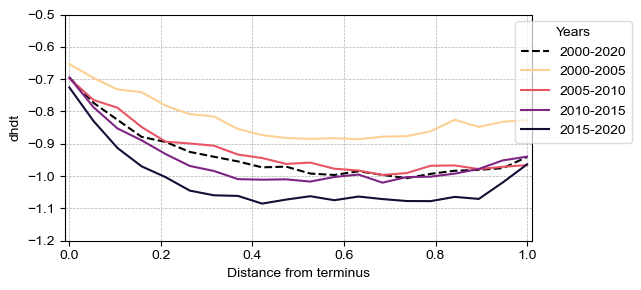

In [18]:
### start figure here

# define xs of the plot
xs = np.linspace(0, 1, len(df_to_use['band'].unique()))
       
intervals = ['2000-01-01_2005-01-01', '2005-01-01_2010-01-01',
             '2010-01-01_2015-01-01', '2015-01-01_2020-01-01',]

# define colors
colors_to_use = iter(plt.cm.magma_r(np.linspace(0.1, 0.9, len(intervals))))

# initiate figure
fig,axs = plt.subplots(figsize=(6.5,3))

# add 20-year average in black dashed line
areas = df_to_use[['band','2000-01-01_2020-01-01']].groupby('band').median()
axs.plot(xs, areas, color='black', label="2000-2020", linestyle='dashed')

# for each year interval, subset the data and plot it
for interval in intervals:

    # subset to just this column
    subset_df = df_to_use[ ['band', interval] ]

    # group by band, take median/mean
    areas = subset_df.groupby('band').median()

    # grab which color we want to use
    color_to_use = next(colors_to_use)

    # plot
    axs.plot(xs, areas, color=color_to_use, label=f"{interval[:4]}-{interval[11:15]}", )

# formatting
axs.grid(zorder=1, linestyle='dashed', linewidth=0.5)
axs.set_xlabel("Distance from terminus")
axs.set_ylabel("dhdt")
axs.set_xlim(-0.01,1.01)
axs.set_ylim(-1.2,-0.5)

# add legend
axs.legend(loc='upper left', title='Years', ncols=1, bbox_to_anchor=(0.95,1), framealpha=0.7)

plt.tight_layout()

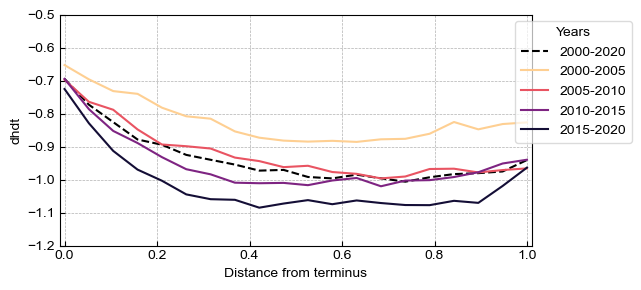

In [19]:
### start figure here
df_to_use = df_dhdt_relative
df_to_use = df_to_use[~df_to_use['rgi_id'].isin(rgi_substantial)]

# define xs of the plot
xs = np.linspace(0, 1, len(df_to_use['band'].unique()))
       
intervals = ['2000-01-01_2005-01-01', '2005-01-01_2010-01-01',
             '2010-01-01_2015-01-01', '2015-01-01_2020-01-01',]

# define colors
colors_to_use = iter(plt.cm.magma_r(np.linspace(0.1, 0.9, len(intervals))))

# initiate figure
fig,axs = plt.subplots(figsize=(6.5,3))

# add 20-year average in black dashed line
areas = df_to_use[['band','2000-01-01_2020-01-01']].groupby('band').median()
axs.plot(xs, areas, color='black', label="2000-2020", linestyle='dashed')

# for each year interval, subset the data and plot it
for interval in intervals:

    # subset to just this column
    subset_df = df_to_use[ ['band', interval] ]

    # group by band, take median/mean
    areas = subset_df.groupby('band').median()

    # grab which color we want to use
    color_to_use = next(colors_to_use)

    # plot
    axs.plot(xs, areas, color=color_to_use, label=f"{interval[:4]}-{interval[11:15]}", )

# formatting
axs.grid(zorder=1, linestyle='dashed', linewidth=0.5)
axs.set_xlabel("Distance from terminus")
axs.set_ylabel("dhdt")
axs.set_xlim(-0.01,1.01)
axs.set_ylim(-1.2,-0.5)
axs.tick_params(axis="both",direction="in")

# add legend
axs.legend(loc='upper left', title='Years', ncols=1, bbox_to_anchor=(0.95,1), framealpha=0.7)

plt.tight_layout()

TypeError: can only concatenate str (not "int") to str

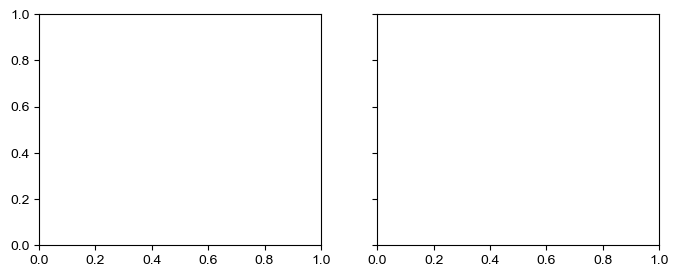

In [20]:
# plot pattern of the entire region

# define intervals to use
intervals = ['2000-01-01_2005-01-01', '2005-01-01_2010-01-01',
                 '2010-01-01_2015-01-01', '2015-01-01_2020-01-01']

# define xs of the plot
xs = np.linspace(0, 1, len(df_to_use_from_here['band'].unique()))
            
# initiate figure
fig,axs = plt.subplots(1,2, figsize=(8,3), sharey='row', sharex=True)

### one column for all glaciers, one column for long glaciers only
for col in [0,1]:
    
    ax = axs[col]
    if col==0: df_to_use = df_to_use_from_here
    else: df_to_use = df_long
    
    # reset color iterator each time
    colors_to_use = iter(plt.cm.magma_r(np.linspace(0.1, 0.9, len(intervals))))
    
    # count number of glaciers included
    n_glaciers = len(df_to_use['rgi_id'].unique())
    
    # for each year interval, subset the data and plot it
    for interval in intervals:

        # format and subset
        ymin = interval[0]
        ymax = interval[1]
        subset_ys = [ str(y) for y in np.arange(ymin,ymax+1) if y in all_ys]
        
        # subset to just these years' columns, take per-glacier median
        subset_df = df_to_use[ subset_ys ].median(axis=1)
        subset_df = pd.DataFrame({'band':df_to_use['band'], 'area':subset_df})
        
        # group by band, take median/mean
        areas = subset_df.groupby('band').mean()

        # grab which color we want to use
        color_to_use = next(colors_to_use)

        # plot
        ax.plot(xs, areas, label=f"{ymin}-{ymax}", color=color_to_use)

    # formatting
    ax.grid(zorder=1, linestyle='dashed', linewidth=0.5)
    ax.set_xlabel("Distance from terminus")
    ax.set_ylabel("SGL Area (%)")
    ax.set_ylim(0,)

    # title
    if col==1:
        ax.set_title(f"All of HMA - Long Glaciers (n={n_glaciers})")
    else:
        ax.set_title(f"All of HMA (n={n_glaciers})")

# add legend to only one plot
axs[1].legend(loc='center left', title='Years', bbox_to_anchor=(1,0.5))

plt.tight_layout()

In [ ]:
# plot every 01 region

# define intervals to use
intervals = [[1990,1999], [2000,2004], [2005,2009], [2010,2014], [2015,2019], [2020,2023]]

# define xs of the plot
xs = np.linspace(0, 1, len(df_to_use_from_here['band'].unique()))

# initiate figure
fig,axs = plt.subplots(3,2, figsize=(8,8), sharey='row', sharex=True)

c=0   
for region in ['15','14','13']:

    for col in [0,1]:
    
        ax = axs[c,col]
        if col==0: df_to_use = df_to_use_from_here
        else: df_to_use = df_long
    
        # subset to this region's data
        g_df = df_to_use[df_to_use['o1region']==region]
        
        # count number of glaciers included
        n_glaciers = len(g_df['rgi_id'].unique())

        # iterate through a color ramp. new color for each interval
        colors_to_use = iter(plt.cm.magma_r(np.linspace(0.1, 0.9, len(intervals))))
        
        # for each year interval, subset the data and plot it
        for interval in intervals:

            # format and subset
            ymin = interval[0]
            ymax = interval[1]
            subset_ys = [ str(y) for y in np.arange(ymin,ymax+1) if y in all_ys]

            # subset to just these years' columns, take per-glacier median
            subset_df = g_df[ subset_ys ].median(axis=1)
            subset_df = pd.DataFrame({'band':g_df['band'], 'area':subset_df})

            # group by band, take median/mean
            areas = subset_df.groupby('band').mean()

            # grab which color we want to use
            color_to_use = next(colors_to_use)

            # plot
            ax.plot(xs, areas, label=f"{ymin}-{ymax}", color=color_to_use)
        
        # formatting
        ax.grid(zorder=1, linestyle='dashed', linewidth=0.5)
        ax.set_xlabel("Distance from terminus")
        ax.set_ylabel("SGL Area (%)")
        ax.set_ylim(0,)

        # title
        if col==1: ax.set_title(f"Region: {region} - Long Glaciers (n={n_glaciers})")
        else: ax.set_title(f"Region: {region} (n={n_glaciers})")
        
        # add legend to only right column
        if col==1: ax.legend(loc='center left', title='Years', bbox_to_anchor=(1,0.5))
    c+=1

plt.tight_layout()

In [ ]:
# plot every 02 region - in region 13

# define intervals to use
intervals = [[1990,1999], [2000,2004], [2005,2009], [2010,2014], [2015,2019], [2020,2023]]


# initiate figure
fig,axs = plt.subplots(5,2, figsize=(8,12), sharey='row', sharex=True)

c=0
for region in ['13-01', '13-02', '13-03', '13-05', '13-09']:

    for col in [0,1]:
    
        ax = axs[c,col]
        if col==0: df_to_use = df_to_use_from_here
        else: df_to_use = df_long
        
        # subset to this glacier's data
        g_df = df_to_use[df_to_use['o2region']==region]
        
        # count number of glaciers included
        n_glaciers = len(g_df['rgi_id'].unique())

        # iterate through a color ramp. new color for each interval
        colors_to_use = iter(plt.cm.magma_r(np.linspace(0.1, 0.9, len(intervals))))

        # define xs of the plot
        xs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


        # for each interval, subset the data and plot it
        for interval in intervals:

            # format and subset
            ymin = interval[0]
            ymax = interval[1]
            subset_df = g_df[ (g_df['year']>=ymin) & (g_df['year']<=ymax) ][xs]
            areas = subset_df.mean(axis=0)#.values

            # grab which color we want to use
            color_to_use = next(colors_to_use)

            # plot
            ax.plot(xs, areas*100, label=f"{ymin}-{ymax}", color=color_to_use)

        # add legend to only right column
        if col==1: ax.legend(loc='center left', title='Years', bbox_to_anchor=(1,0.5))

        # formatting
        ax.grid(zorder=1, linestyle='dashed', linewidth=0.5)
        ax.set_xlabel("Distance from terminus")
        ax.set_ylabel("SGL Area (%)")
        ax.set_ylim(0,)

        # title
        if col==1: ax.set_title(f"Region: {region} - Long Glaciers (n={n_glaciers})")
        else: ax.set_title(f"Region: {region} (n={n_glaciers})")
    c+=1

plt.tight_layout()

In [ ]:
# plot every 02 region - in region 14

# define intervals to use
intervals = [[1990,1999], [2000,2004], [2005,2009], [2010,2014], [2015,2019], [2020,2023]]

# define xs of the plot
xs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# initiate figure
fig,axs = plt.subplots(3,2, figsize=(8,8), sharey='row', sharex=True)

c=0
for region in ['14-01', '14-02', '14-03']:
    
    for col in [0,1]:
    
        ax = axs[c,col]
        if col==0: df_to_use = df_to_use_from_here
        else: df_to_use = df_long

        # subset to this glacier's data
        g_df = df_to_use[df_to_use['o2region']==region]
        
        # count number of glaciers included
        n_glaciers = len(g_df['rgi_id'].unique())

        # iterate through a color ramp. new color for each interval
        colors_to_use = iter(plt.cm.magma_r(np.linspace(0.1, 0.9, len(intervals))))
        
        # for each interval, subset the data and plot it
        for interval in intervals:

            # format and subset
            ymin = interval[0]
            ymax = interval[1]
            subset_df = g_df[ (g_df['year']>=ymin) & (g_df['year']<=ymax) ][xs]
            areas = subset_df.mean(axis=0)#.values

            # grab which color we want to use
            color_to_use = next(colors_to_use)

            # plot
            ax.plot(xs, areas*100, label=f"{ymin}-{ymax}", color=color_to_use)

        # add legend
        if col==1: ax.legend(loc='center left', title='Years', bbox_to_anchor=(1,0.5))

        # formatting
        ax.grid(zorder=1, linestyle='dashed', linewidth=0.5)
        ax.set_xlabel("Distance from terminus")
        ax.set_ylabel("SGL Area (%)")
        ax.set_ylim(0,)

        # title
        if col==1: ax.set_title(f"Region: {region} - Long Glaciers (n={n_glaciers})")
        else: ax.set_title(f"Region: {region} (n={n_glaciers})")
    c+=1

plt.tight_layout()

In [ ]:
# plot every 02 region - in region 15

# define intervals to use
intervals = [[1990,1999], [2000,2004], [2005,2009], [2010,2014], [2015,2019], [2020,2023]]

# define xs of the plot
xs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# initiate figure
fig,axs = plt.subplots(3,2, figsize=(8,8), sharey='row', sharex=True)

c=0
for region in ['15-01', '15-02', '15-03']:
    
    for col in [0,1]:
    
        ax = axs[c,col]
        if col==0: df_to_use = df_to_use_from_here
        else: df_to_use = df_long

        # subset to this glacier's data
        g_df = df_to_use[df_to_use['o2region']==region]
        
        # count number of glaciers included
        n_glaciers = len(g_df['rgi_id'].unique())

        # iterate through a color ramp. new color for each interval
        colors_to_use = iter(plt.cm.magma_r(np.linspace(0.1, 0.9, len(intervals))))
        
        # for each interval, subset the data and plot it
        for interval in intervals:

            # format and subset
            ymin = interval[0]
            ymax = interval[1]
            subset_df = g_df[ (g_df['year']>=ymin) & (g_df['year']<=ymax) ][xs]
            areas = subset_df.mean(axis=0)#.values

            # grab which color we want to use
            color_to_use = next(colors_to_use)

            # plot
            ax.plot(xs, areas*100, label=f"{ymin}-{ymax}", color=color_to_use)

        # add legend
        if col==1: ax.legend(loc='center left', title='Years', bbox_to_anchor=(1,0.5))

        # formatting
        ax.grid(zorder=1, linestyle='dashed', linewidth=0.5)
        ax.set_xlabel("Distance from terminus")
        ax.set_ylabel("SGL Area (%)")
        ax.set_ylim(0,)

        # title
        if col==1: ax.set_title(f"Region: {region} - Long Glaciers (n={n_glaciers})")
        else: ax.set_title(f"Region: {region} (n={n_glaciers})")
    c+=1

plt.tight_layout()

In [ ]:
# publication-ready figures

# define intervals to use
intervals = [[1990,1999], [2000,2004], [2005,2009], [2010,2014], [2015,2019], [2020,2023]]
all_ys = [1988,1990,1992,1994,1996,1998,2000,2002,2004] + list(range(2005,2024))

# define xs of the plot
xs = np.linspace(0, 1, len(df_to_use_from_here['band'].unique()))
            
# initiate figure
fig,axs = plt.subplots(figsize=(6.5,3), sharey='row', sharex=True)

### just plot all glaciers. don't worry about long vs short
df_to_use = df_long
    
# color iterator
colors_to_use = iter(plt.cm.magma_r(np.linspace(0.1, 0.9, len(intervals))))

# count number of glaciers included
n_glaciers = len(df_to_use['rgi_id'].unique())

# for each year interval, subset the data and plot it
for interval in intervals:

    # format and subset
    ymin = interval[0]
    ymax = interval[1]
    subset_ys = [ str(y) for y in np.arange(ymin,ymax+1) if y in all_ys]

    # subset to just these years' columns, take per-glacier median
    subset_df = df_to_use[ subset_ys ].median(axis=1)
    subset_df = pd.DataFrame({'band':df_to_use['band'], 'area':subset_df})

    # group by band, take median/mean
    areas = subset_df.groupby('band').mean()

    # grab which color we want to use
    color_to_use = next(colors_to_use)

    # plot
    axs.plot(xs, areas, label=f"{ymin}–{ymax}", color=color_to_use, linewidth=2.5)


# formatting
axs.set_xlabel("Normalized distance from terminus")
axs.set_ylabel("SGL Area (%)")
axs.set_ylim(0,)
axs.set_xlim(-0.01, 1.01)
axs.grid(zorder=1, linestyle='dashed', linewidth=0.5)
axs.tick_params(axis="both",direction="in")

# add legend to only one plot
axs.legend(loc='upper right', title='Years', ncols=2, bbox_to_anchor=(1,1), framealpha=1)

plt.tight_layout()

In [ ]:
# plot every 01 region

# define intervals to use
intervals = [[1990,1999], [2000,2004], [2005,2009], [2010,2014], [2015,2019], [2020,2023]]
all_ys = [1988,1990,1992,1994,1996,1998,2000,2002,2004] + list(range(2005,2024))

# define xs of the plot
xs = np.linspace(0, 1, len(df_to_use_from_here['band'].unique()))
            
### just plot all glaciers. don't worry about long vs short
df_to_use = df_long

# initiate figure
fig,axs = plt.subplots(3,1, figsize=(6.5,7))

c=0   
for region in ['13','14','15']:

    ax = axs[c]

    # subset to this region's data
    g_df = df_to_use[df_to_use['o1region']==region]

    # count number of glaciers included
    n_glaciers = len(g_df['rgi_id'].unique())

    # restart color iterator each time
    colors_to_use = iter(plt.cm.magma_r(np.linspace(0.1, 0.9, len(intervals))))

    # for each year interval, subset the data and plot it
    for interval in intervals:

        # format and subset
        ymin = interval[0]
        ymax = interval[1]
        subset_ys = [ str(y) for y in np.arange(ymin,ymax+1) if y in all_ys]

        # subset to just these years' columns, take per-glacier median
        subset_df = g_df[ subset_ys ].median(axis=1)
        subset_df = pd.DataFrame({'band':g_df['band'], 'area':subset_df})

        # group by band, take median/mean
        areas = subset_df.groupby('band').mean()

        # grab which color we want to use
        color_to_use = next(colors_to_use)

        # plot
        ax.plot(xs, areas, label=f"{ymin}-{ymax}", color=color_to_use, linewidth=2.5)
    
    ax.set_ylabel("SGL Area (%)")
    ax.set_ylim(0,)
    ax.set_xlim(-0.01, 1.01)
    ax.grid(zorder=1, linestyle='dashed', linewidth=0.5)
    ax.tick_params(axis="both",direction="in")

    c+=1

axs[-1].set_xlabel("Normalized distance from terminus")

# add legends one by one
axs[0].legend(loc='upper right', title=f'Central Asia', ncols=2, bbox_to_anchor=(1,1), framealpha=1)
axs[1].legend(loc='upper right', title=f'South Asia West', ncols=2, bbox_to_anchor=(1,1), framealpha=1)
axs[2].legend(loc='upper right', title=f'South Asia East', ncols=2, bbox_to_anchor=(1,1), framealpha=1)

plt.tight_layout()